In [1]:
# 기본 라이브러리
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

mpl.rc('font', family = 'Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 모델 라이브러리
from sklearn.model_selection    import train_test_split
from imblearn.pipeline          import make_pipeline             # 불균형 데이터를 위한 imblearn.pipeline
from sklearn.compose            import make_column_transformer   # 문자 숫자 따로 처리
from sklearn.impute             import SimpleImputer             # 결측값 처리
from sklearn.preprocessing      import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling     import SMOTE                     # 불균형 데이터 처리 기법
from sklearn.ensemble           import RandomForestClassifier
from sklearn.model_selection    import GridSearchCV              # 교차검증 및 하이퍼파라미터 튜닝
from sklearn.metrics            import classification_report     # 모델 평가

import pickle   # 모델 저장

In [3]:
# Web에 넣을 모델을 구성
df1 = pd.read_csv('./data/01_Data.csv')
df1

,Index,Member_ID,Sales_Type,Contract_Type,Channel,Datetime,Term,Payment_Type,Product_Type,Amount_Month,Customer_Type,Age,Address1,Address2,State,Overdue_count,Overdue_Type,Gender,Credit_Rank,Bank
0,1,66758234,렌탈,일반계약,영업방판,2019-05-06,60,CMS,DES-1,96900,개인,42.0,경기도,경기도,계약확정,0,없음,여자,9.0,새마을금고
1,2,66755948,렌탈,교체계약,영업방판,2020-02-20,60,카드이체,DES-1,102900,개인,39.0,경기도,경기도,계약확정,0,없음,남자,2.0,현대카드
2,3,66756657,렌탈,일반계약,홈쇼핑/방송,2019-02-28,60,CMS,DES-1,96900,개인,48.0,경기도,경기도,계약확정,0,없음,여자,8.0,우리은행
3,4,66423450,멤버십,멤버십3유형,재계약,2019-05-13,12,CMS,DES-1,66900,개인,39.0,경기도,경기도,계약확정,0,없음,남자,5.0,농협회원조합
4,5,66423204,멤버십,멤버십3유형,재계약,2019-05-10,12,CMS,DES-1,66900,개인,60.0,경기도,경기도,기간만료,12,있음,남자,8.0,농협회원조합
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51296,51298,66579515,렌탈,프로모션계약,대형마트A,2019-03-01,60,CMS,DES-3A,96900,개인,47.0,경기도,경기도,계약확정,0,없음,남자,NaN,기업은행
51297,51299,66799558,렌탈,일반계약,대형마트A,2019-04-01,60,CMS,DES-1,96900,개인,42.0,경기도,경기도,계약확정,0,없음,여자,8.0,새마을금고
51298,51300,66799197,렌탈,프로모션계약,영업방판,2019-04-01,39,카드이체,ERA,120900,개인,65.0,서울특별시,서울특별시,계약확정,0,없음,여자,1.0,롯데카드
51299,51301,66792778,렌탈,일반계약,홈쇼핑/방송,2020-02-06,60,카드이체,DES-1,96900,개인,54.0,서울특별시,서울특별시,계약확정,0,없음,여자,2.0,롯데카드


In [4]:
# 1) 데이터 핸들링 수행
df1['State'].unique()
df1['Target'] = df1['State'].replace({'계약확정' : 0,
                      '기간만료': 1, '해약확정' : 1, '해약진행중' : 1})
df1['Target'].value_counts()

0    50620
1      681
Name: Target, dtype: int64

In [5]:
# 2) 목표변수와 설명변수를 선언
X = df1[['Term','Amount_Month','Product_Type','Age','Gender','Credit_Rank']]
Y = df1['Target']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # stratify = Y, 

In [7]:
# 파이프라인 (특성공학 + 학습)
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

numeric_list = X.select_dtypes(exclude = 'object').columns.tolist()
category_list = X.select_dtypes(include = 'object').columns.tolist()

preprocessing_pipe = make_column_transformer( (numeric_pipe, numeric_list),
                                              (category_pipe, category_list))

model_pipe = make_pipeline(preprocessing_pipe, SMOTE(), RandomForestClassifier(random_state=42))

In [8]:
# 교차검증 및 하이퍼파라미터 튜닝
hyper_param = {'randomforestclassifier__max_depth' : range(5,15),
               'randomforestclassifier__min_samples_split' : range(10,20),
               'randomforestclassifier__min_samples_leaf' : range(10,20),
               'randomforestclassifier__class_weight' : ['balanced']}
grid_model = GridSearchCV(model_pipe, cv = 3, param_grid={ },
                          scoring='f1', n_jobs = -1)
grid_model.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Term',
                                                                          'Amount_Month',
                                                                          'Age',
                                                                          'Credit_Rank']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['Product_Type',
                                                                          'Gender'])])),
                                       ('smote', SMOTE()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1, param_grid={}, scoring='f1')

In [9]:
best_model = grid_model.best_estimator_

def evaluation_classifier(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    res_train = pd.DataFrame(report_train).T
    
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    res_test = pd.DataFrame(report_test).T
    display(res_train)
    display(res_test)
    
evaluation_classifier(best_model)

,precision,recall,f1-score,support
0,0.992050,0.958506,0.974990,40488.000000
1,0.125455,0.436594,0.194905,552.000000
accuracy,0.951486,0.951486,0.951486,0.951486
macro avg,0.558753,0.697550,0.584947,41040.000000
weighted avg,0.980394,0.951486,0.964497,41040.000000


,precision,recall,f1-score,support
0,0.988947,0.953711,0.971009,10132.000000
1,0.042857,0.162791,0.067851,129.000000
accuracy,0.943768,0.943768,0.943768,0.943768
macro avg,0.515902,0.558251,0.519430,10261.000000
weighted avg,0.977053,0.943768,0.959655,10261.000000


In [10]:
pickle.dump(best_model, open('./실습 저장파일/model_RF.sav','wb'))

In [11]:
# 해약 여부 분류 --> 해약 확률을 계산
new_data = pd.DataFrame(data = [[60,150000, 'DES-1', 30, '남자', 9]],
             columns = ['Term','Amount_Month','Product_Type','Age','Gender','Credit_Rank'])

best_model.predict_proba(new_data)

array([[0.98, 0.02]])

- __Threshold Tuning (Cut off Tuning)__
    - 분류 확률의 기준을 바꾸어, 분류를 다르게 수행
    - 분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임계값을 조정하여 정밀도 또는 재현율의 수치를 높일 수 있음
    - 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용됨
    - __!!! 모델은 그대로 !!!__

In [12]:
## 기준은 0.5지만
## 그 기준을 0.2 0.3 등 과 같이 사용자가 임의로 분류 기준을 바꾸어 준다
## 해약, 정상 분류 확률을 계산하여, 해약될 확률만 추출
from sklearn.preprocessing import Binarizer

pred_proba = best_model.predict_proba(x_test)
print(pred_proba)
pred_proba_reshape = pred_proba[:,1].reshape(-1,1) # 해약할 확률

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
# 해약하라 확률이 default인 50%가 아닌 30% 이상인 데이터를 모두 해약으로 예측
y_test_pred_30 = Binarizer(threshold=0.3).fit_transform(pred_proba_reshape)

report_test = classification_report(y_test, y_test_pred_30, output_dict=True)
res_test = pd.DataFrame(report_test).T

# Threshold(분류 판단기준)을 변경하게 되면, Recall 올라갈 때, Precision 떨어지거나
# Precision 올라갈 때, Recall 떨어지는 현상이 발생
# Precision-Recall Trade off

# 모델의 성능이 올라가는 것 처럼 보이지만?
# 단지 threshold에 따른 precision,recall 값이 Trade off되며 변하는 것

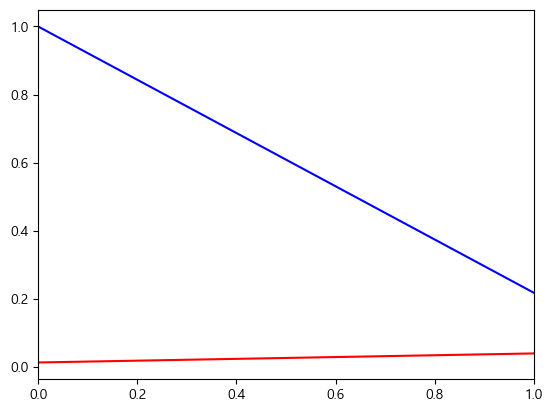

In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, y_test_pred_30)

plt.plot(threshold, precision[0 : threshold.shape[0]], c = 'r')
plt.plot(threshold, recall[0 : threshold.shape[0]], c = 'b')
plt.xlim(threshold)
plt.show()